In [ ]:
#HEADER

#Imports
from qutip import *
import math
#from math import *
import cmath
#from cmath import *
import time
from qutip.ipynbtools import version_table

%matplotlib inline
import matplotlib.pyplot as plt
#from matplotlib.pyplot import *
import numpy as np
from pylab import *
from matplotlib import cm
#from numpy import *
from mpl_toolkits.mplot3d.axes3d import Axes3D

#Update the matplotlib configuration parameters:
plt.rcParams.update({'font.size': 17, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})


#Important/Useful shortcut-functions
#Euler-functions
def euler1(a): #for a in [0,2pi]
    return cmath.exp(1j*a)

def euler3(a): #for a in [0,1]
    return cmath.exp(1j*cmath.tau*a)

def C(z): #Conjugate of complex number
    return z.conjugate()

def Q(z): #Absolute square of complex number
    #return z*z.conjugate()
    return (abs(z))**2

def fak(k): #Faculty
    if k<1:
        return 1
    else:
        f=1
        for i in range(1,k+1):
            f=f*i
        return f

def flat(a): #Flattens scalar Q-Objects (mostly scalar-products) to complex number type
    #b=a[0][0]
    #return b[0]
    return a[0][0][0]

def flat2(a): #Flattens scalar Q-Objects to real number type, gives ComplexWarning
    #return float(a[0][0][0])
    return (a[0][0][0]).real
    #return flat(a).real

def two(a): #returns symmetrical two-mode Q-Object from single-mode Q-Object
    return tensor(a,a)


#Basic operators and states (for dim N)
#Null-element-functions
def null(N): #null-fock-state
    return fock(N,0)-fock(N,0)

def null2(q): #null-element of any Q-type of object q
    return q-q

def UnitN(N): #unit-element/matrix of dim N
    return (destroy(N))**0

def Unit(op): #unit-element/matrix of any Q-type of operator q
    return op**0

def Unit2(A): #unit-element/matrix of any Q-type w/ dim of state A
    return Unit(A*A.dag())

def dual(op,i): #returns two-mode operator from single-mode operator w/ respect to 1st mode (i=0) and 2nd mode (i=1 or i=/=0)
    if i==0:
        return tensor(op, Unit(op)) #Unit(op)
    else:
        return tensor(Unit(op), op)

def nop(N): #Photon-number-operator
    return create(N)*destroy(N)

def H(N): #Hamilton-operator
    return nop(N)+0.5
    #return create(N)*destroy(N)+0.5

def fop(N,n): #fock-state operator, returns fock(N,n) when applied to fock(N,0)
    s=(create(N)**n)/math.sqrt(fak(n))
    return s

def Dis(N,a): #displacement-operator for coherent state w/ dim N & amplitude a
    return ((a.conjugate())*create(N)-a*destroy(N)).expm()


#Quadratures
def X(N): #location
    return (destroy(N)+create(N))/math.sqrt(2)

def P(N): #momentum
    return -1j*(destroy(N)-create(N))/math.sqrt(2)


#Basic Q-Object-Operations
def com(op1,op2): #commutator, alternative: commutator(op1, op2)
    return op1*op2-op2*op1

def scalar(a,b): #scalar product
    return flat(a.dag()*b) #complex type

def square(a): #absolute square
    return (a.norm())**2

def dens(a): #density operator for pure state, implemented alternative: ket2dm()
    return a*a.dag()

def TN(p): #trace-norm for density matrix p
    return ((p.dag()*p).sqrtm()).tr()


#Basic Q-measures for operator(s) Op and state A, must be compatible
def Dev(Op,A): #(Dynamic) Deviation/Deviation-Operator
    return Op-expect(Op,A)

def SD(Op,A): #Standard-Deviation/Uncertainty
    return math.sqrt(variance(Op,A))

def Covar(Op1,Op2,A): #Covariance, complex type
    return expect((Op1*Op2),A)-expect(Op1,A)*expect(Op2,A)


#Miscellaneous
def Pois(mean,n): #Poisson-distribution
    return (mean**n)*math.exp(-mean)/fak(n)

In [ ]:
#--------------------#
#MAIN FOUR-MODE SYSTEM
#--------------------#

#Loss-parameters, change here!
eta=0.3
ny=0.4

#4-Mode vacuum state
def vacuum(N):
    return two(two(fock(N,0)))

#single-mode modified/lossy number operator
def monop(N):
    return eta*nop(N)+ny


#returns 4-mode-tensor of single-mode operator b for mode i=1,2,3,else; analogous to a(N,i), mostly for output-modes!
def Mode(b,i): #(b,i)
    u=Unit(b)
    if i==1:
        return tensor(b,u,u,u)
    elif i==2:
        return tensor(u,b,u,u)
    elif i==3:
        return tensor(u,u,b,u)
    else:
        return tensor(u,u,u,b)


#4-Mode Beam-Splitter: returns incoming ladder-operators a1-4 from outcoming ones a5-8; 1: signal-input, 3: signal-side,
#2: idler-input, 4: idler-side
def a(T,N,i):
    #T=0.9 #Transmittivity
    t=math.sqrt(T) #Optical coefficients
    r=math.sqrt(1-T)
    MainS=Mode(t*destroy(N), 1)+Mode(r*destroy(N), 3)
    MainI=Mode(t*destroy(N), 2)+Mode(r*destroy(N), 4)
    SideS=Mode(-r*destroy(N), 1)+Mode(t*destroy(N), 3)
    SideI=Mode(-r*destroy(N), 2)+Mode(t*destroy(N), 4)
    #i=1,3: signal; i=2,4: idler
    #i=1,2: main, i=3,4: side
    if i==1:
        return MainS
    elif i==2:
        return MainI
    elif i==3:
        return SideS
    else:
        return SideI


#fock-state displacement-operator for altered ladder-operators, for input-modes, i for modes
def fop2(T,N,n,i):
    return ((a(T,N,i).dag())**n)/math.sqrt(fak(n))


#4-Mode Detector-operator, i for modes
def detec(N,n,i):
    return Mode(fock_dm(N,n), i)

#single-mode Modified detector-operator for lossy detection
def sdetec2(N,n):
    eff=monop(N)
    op=((eff**n)/fak(n))*(-eff).expm()
    return op

#4-Mode Modified detector-operator for lossy detection, i for modes
def detec2(N,n,i):
    eff=monop(N)
    op=((eff**n)/fak(n))*(-eff).expm()
    return Mode(op,i)


#squeezed state operator for altered ladder-operators, for Main-modes (1,2)
def squeeze2(z,T,N,ls,li): #as operator to be applied to fock(N,0)
    l=max([ls,li])
    s=null2(Mode(destroy(N), 1))
    for n in range(N+l): #range(N)
        s=s+(z**n)*(fop2(T,N,n,1)*fop2(T,N,n,2))
    s=s*math.sqrt(1-Q(z))
    return s


#altered displacement-operator for coherent state
def Dis2(T,N,aa,i):
    return (aa*a(T,N,i).dag()-C(aa)*a(T,N,i)).expm()


#Input state w/ Ls & Li for *added* pn-states at input-Side-modes (3,4)
def Input(z,T,N,Ls,Li,ls,li): #(z,N,Ls,Li)
    s=squeeze2(z,T,N,ls,li)*fop2(T,N,Ls,3)*fop2(T,N,Li,4)*vacuum(N)
    return s


#Input State after detectors in Side-modes, w/ ls & li for *subtracted* pn-states at output-Side-modes ###
def State(z,T,N,Ls,Li,ls,li):
    s=detec(N,ls,3)*detec(N,li,4)*Input(z,T,N,Ls,Li,ls,li)
    s=s.unit()
    return s

#State(...), but lossy
def MState(z,T,N,Ls,Li,ls,li):
    s=detec2(N,ls,3)*detec2(N,li,4)*Input(z,T,N,Ls,Li,ls,li)
    s=s.unit()
    return s

In [ ]:
#APPLICATIONS OF QUANTUM STATE

#Ladder-Operators applied to Main-modes; As: signal, Ai: idler
def As(N):
    return Mode(destroy(N), 1)

def Ai(N):
    return Mode(destroy(N), 2)


#Probability to detect m (signal) & n (idler) photons in Main-modes, for l-modified Input state ###
#A: 4-mode state of interest
#Test 1: ideal, for Main-detectors only, applied to *l-modified state*
def Prob1(A,z,N,Ls,Li,ls,li,m,n):
    Op=detec(N,m,1)*detec(N,n,2) #ideal detector
    s=expect(Op,A)
    return s

#Test 2: ideal, for both Main- & Side-detectors, applied to *input state*
def Prob2(A,z,N,Ls,Li,ls,li,m,n):
    Op=detec(N,m,1)*detec(N,n,2)*detec(N,ls,3)*detec(N,li,4) #ideal detector
    s=expect(Op,A)
    return s

#Test 3: lossy, for Main-detectors only, applied to *l-modified state*
def MProb1(A,z,N,Ls,Li,ls,li,m,n):
    Op=detec2(N,m,1)*detec2(N,n,2) #lossy detector
    s=expect(Op,A)
    return s

#Test 2: for both Main- & Side-detectors, applied to *input state*
def MProb2(A,z,N,Ls,Li,ls,li,m,n):
    Op=detec2(N,m,1)*detec2(N,n,2)*detec2(N,ls,3)*detec2(N,li,4) #lossy detector
    s=expect(Op,A)
    return s

#Try Prob1 or Prob2 (ideal); MProb1 or MProb2 (lossy)
def Prob(A,z,N,Ls,Li,ls,li,m,n,t):
    #return Prob1(A,z,N,Ls,Li,ls,li,m,n)
    #return Prob2(A,z,N,Ls,Li,ls,li,m,n)
    #return MProb1(A,z,N,Ls,Li,ls,li,m,n)
    #return MProb2(A,z,N,Ls,Li,ls,li,m,n)
    if t==0:
        return Prob1(A,z,N,Ls,Li,ls,li,m,n)
    else:
        return MProb1(A,z,N,Ls,Li,ls,li,m,n)


#Agarwal-Parameter for 4-mode-state A, applied to Main-modes
def Agarwal(A,N):
    a=expect((As(N).dag()**2)*(As(N)**2), A)*expect((Ai(N).dag()**2)*(Ai(N)**2), A)
    b=expect(As(N).dag()*As(N)*Ai(N).dag()*Ai(N), A)
    return (math.sqrt(a)/b)-1


#Correlation-function of 2nd order g[2](0) for 4-mode-state A, applied to Main-modes
def Corr(A,N):
    a=expect(As(N).dag()*Ai(N).dag()*Ai(N)*As(N), A) #normal ordering?
    #a=expect(As(N).dag()*As(N)*Ai(N).dag()*Ai(N), A) #alternative ordering
    b=expect(As(N).dag()*As(N), A)*expect(Ai(N).dag()*Ai(N), A)
    return a/b


#Determinant of Moment-Matrix (M[2,2]) from its elements ###Test
def DetMom(z,T,N,Ls,Li,ls,li,t,u):
    if u==0:
        A=State(z,T,N,Ls,Li,ls,li)
    else:
        A=MState(z,T,N,Ls,Li,ls,li)
    ms=mi=ms2=mi2=msi=0
    for m in range(N):
        for n in range(N):
            p=Prob(A,z,N,Ls,Li,ls,li,m,n,t)
            ms=ms+m*p
            mi=mi+n*p
            ms2=ms2+m*(m-1)*p
            mi2=mi2+n*(n-1)*p
            msi=msi+m*n*p
    s=(ms2-ms**2)*(mi2-mi**2)-(msi-ms*mi)**2
    return s

#shortcut for DetMom() for Prob1(): only goes along diagonal m=n=o
def DetMom3(z,T,N,Ls,Li,ls,li):
    #A=MState(z,T,N,Ls,Li,ls,li)
    A=State(z,T,N,Ls,Li,ls,li)
    m=m2=msi=0
    for o in range(N):
        p=Prob1(A,z,N,Ls,Li,ls,li,o,o)
        m=m+p*o
        m2=m2+p*o*(o-1)
        msi=msi+p*o**2
    s=(m2-m**2)**2-(msi-m**2)**2
    return s

bell=(tensor(fock(2,0), fock(2,0))+tensor(fock(2,1), fock(2,1)))/math.sqrt(2)
bellt=partial_transpose(ket2dm(bell), [1,0])
ebit=math.log2(((bellt.dag()*bellt).sqrtm()).tr())


#Logarithmic Negativity of State A
def LogNeg(A,N):
    #2 main modes traced out, new mode order
    #s=partial_transpose((A.ptrace([0,1])).unit(), [1,0]) #<-reasonably quick and stable up to 14
    #s=partial_transpose((A.ptrace([0,1])).unit(), [0,1])
    #2 main modes traced out, new mode order, for pre-normalized state
    s=partial_transpose((A.ptrace([0,1])), [1,0]) #<-reasonably quick and stable up to 14
    #s=partial_transpose((A.ptrace([0,1])), [0,1])

    r=((s.dag()*s).sqrtm()).tr()
    #r=TN(s)
    if r>1:
        r=math.log2(r)
    else:
        r=0
    return r

def LNRef(z):
    return math.log2((1-z)/(1+z))


ebit

0.9999999999999997

In [5]:
#PRODUCING ARRAYS

#special Arraymaker for functions of form F(A,N)
def ArrayAN(F,A,z,T,N,Ls,Li,ls,li): #(F,A,z,N,Ls,Li,ls,li)
    y=[]
    for zz in z: #run tru z
        #y.append(F(zz,T,N,Ls,Li,ls,li)) #for functions of form: F(zz,N,Ls,Li,ls,li) - DetMom
        y.append(F(A(zz,T,N,Ls,Li,ls,li), N)) #for functions of form: F(A,N) - Agarwal, Corr, LogNeg
        #f=A(zz,T,N,Ls,Li,ls,li)
        #y.append(F(f,N))
        print(zz)
    print("\n")
    return np.array(y)

#special Arraymaker for functions of form F(A,N), for 3d-surface-plots of F(z,T)
def ArrayAN2(F,A,z,T,N,Ls,Li,ls,li,d): #d: pick 1: Diff; 0: LogNeg
    y=[]
    for TT in T:
        yy=[]
        for zz in z:
            if d>0:
                p=F(A(zz,TT,N,Ls,Li,ls,li), N)-math.log2((1+zz)/(1-zz)) #for difference of LogNeg
                if p<0:
                    p=0
                else:
                    pass
            else:
                p=F(A(zz,TT,N,Ls,Li,ls,li), N) #for functions of form: F(A,N) - Agarwal, Corr, LogNeg
            yy.append(p)
        y.append(yy)
        print(TT)
    print("\n")
    return np.array(y)


#Relative Error
def Rel(a,b):
    return abs((a-b)/b)

In [ ]:
#Agarwal-Test
Time=time.time()
plt.rcParams.update({'font.size': 17, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

N=15
T=0.9
steps=18
lim1=0.05
lim2=0.95

v=2 #1:sub, 2: add, 3: replace
Ls=0
Li=Ls
ls=0
li=Ls
z=np.linspace(lim1,lim2,steps+1)
y=[]
c=['b','m','r','g']

fig=plt.figure(figsize=(9,6))
for l in range(4):
    if v==1:
        y.append(ArrayAN(Agarwal,State,z,T,N,Ls,Li,l,l)) #sub
        plt.plot(z, y[l], color=c[l], label='$l=$'+str(l))
    elif v==2:
        y.append(ArrayAN(Agarwal,State,z,T,N,l,l,ls,li)) #add
        plt.plot(z, y[l], color=c[l], label='$L=$'+str(l))
    else:
        y.append(ArrayAN(Agarwal,State,z,T,N,l,l,l,l)) #rep
        plt.plot(z, y[l], color=c[l], label='$L=l=$'+str(l))
plt.xlabel('Squeezing Parameter $z$', fontsize=20)
plt.ylabel('Agarwal Parameter $I(z)$', fontsize=20)
#plt.title("$N=$"+str(N)+", $L=$"+str(Ls), fontsize=20) #l_{+}
plt.grid(True)
plt.legend(loc=0)
if v==1:
    plt.title("Subtraction: $N=$"+str(N)+", $L=$"+str(Ls), fontsize=20)
    plt.savefig("Agarwal_N"+str(N)+"_L"+str(Ls)+"_step"+str(steps)+"_start"+str(lim1)+"_sub.pdf", bbox_inches='tight')
elif v==2:
    plt.title("Addition: $N=$"+str(N)+", $l=$"+str(ls), fontsize=20)
    plt.savefig("Agarwal_N"+str(N)+"_l"+str(ls)+"_step"+str(steps)+"_start"+str(lim1)+"_add.pdf", bbox_inches='tight')
else:
    plt.title("Replacement: $N=$"+str(N), fontsize=20)
    plt.savefig("Agarwal_N"+str(N)+"_step"+str(steps)+"_start"+str(lim1)+"_rep.pdf", bbox_inches='tight')
#plt.savefig("Agarwal_N"+str(N)+"_L"+str(Ls)+"_step"+str(steps)+"_start"+str(lim1)+".pdf", bbox_inches='tight')
#plt.savefig("Agarwal_N"+str(N)+"_L"+str(Ls)+"_step"+str(steps)+"_start"+str(lim1)+"_2mode.pdf", bbox_inches='tight') #_2mode
#plt.savefig("Agarwal_N"+str(N)+"_L"+str(Ls)+"_step"+str(steps)+"_start"+str(lim1)+"_nu4mode.pdf", bbox_inches='tight')
plt.show()

print("Time of Execution:",time.time()-Time,"seconds")

0.05
0.1


0.4
0.445833333333
0.491666666667
0.5375
0.583333333333
0.629166666667
0.675
0.720833333333
0.766666666667
0.8125
0.858333333333
0.904166666667
0.95


0.4
0.445833333333
0.491666666667
0.5375
0.583333333333
0.629166666667
0.675
0.720833333333
0.766666666667
0.8125
0.858333333333
0.904166666667
0.95


0.4
0.445833333333
0.491666666667
0.5375
0.583333333333
0.629166666667
0.675
0.720833333333
0.766666666667
0.8125
0.858333333333
0.904166666667
0.95


0.4
0.445833333333
0.491666666667
0.5375
0.583333333333
0.629166666667
0.675
0.720833333333
0.766666666667
0.8125
0.858333333333
0.904166666667
0.95




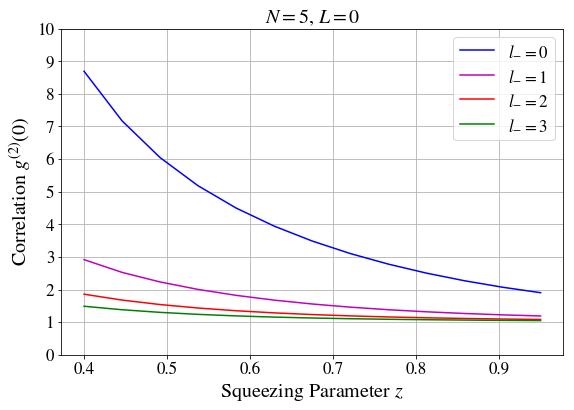

In [ ]:
#Corr-Test
Time=time.time()
plt.rcParams.update({'font.size': 17, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

N=20
T=0.9
steps=48
lim1=0.25
lim2=0.95

Ls=0
Li=Ls
ls=0
li=Ls
z=np.linspace(lim1,lim2,steps+1)

y=[]
c=['b','m','r','g']
p=np.arange(11)

fig=plt.figure(figsize=(9,6))
for l in range(4):
    y.append(ArrayAN(Corr,State,z,T,N,Ls,Li,l,l))
    plt.plot(z, y[l], color=c[l], label='$l_{-}=$'+str(l))
plt.xlabel('Squeezing Parameter $z$', fontsize=20)
plt.ylabel('Correlation $g^{(2)}(0)$', fontsize=20)
plt.ylim([0,10])
plt.yticks(p)
plt.title("$N=$"+str(N)+", $L=$"+str(Ls), fontsize=20) #l_{+}
plt.grid(True)
plt.legend(loc=0)
plt.savefig("Corr_N"+str(N)+"_L"+str(Ls)+"_step"+str(steps)+"_start"+str(lim1)+".pdf", bbox_inches='tight')
plt.show()

print("Time of Execution:",time.time()-Time,"seconds")

0.049
0.099
0.149
0.199
0.249
0.299
0.349
0.399
0.449
0.499
0.549
0.599
0.649
0.699
0.749
0.799
0.849
0.899
0.949
0.999


0.049
0.099
0.149
0.199
0.249
0.299
0.349
0.399
0.449
0.499
0.549
0.599
0.649
0.699
0.749
0.799
0.849
0.899
0.949
0.999


0.049
0.099
0.149
0.199
0.249
0.299
0.349
0.399
0.449
0.499
0.549
0.599
0.649
0.699
0.749
0.799
0.849
0.899
0.949
0.999


0.049
0.099
0.149
0.199
0.249
0.299
0.349
0.399
0.449
0.499
0.549
0.599
0.649
0.699
0.749
0.799
0.849
0.899
0.949
0.999




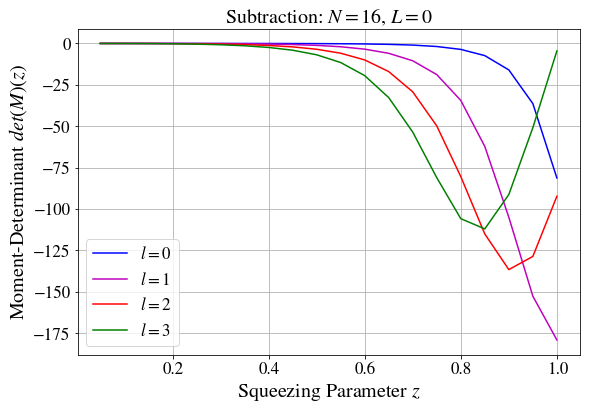

Time of Execution: 765.3677723407745 seconds


In [24]:
#Moment-Matrix-Determinant-Test
Time=time.time()
plt.rcParams.update({'font.size': 17, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

def ArrayDM(z,T,N,Ls,Li,ls,li,t,u): #(F,A,z,N,Ls,Li,ls,li) #(F,z,N,Ls,Li,ls,li)
    y=[]
    for zz in z:
        if t==0 & u==0:
            y.append(DetMom3(zz,T,N,Ls,Li,ls,li)) #for functions of form: F(zz,N,Ls,Li,ls,li) - DetMom3
        else:
            y.append(DetMom(zz,T,N,Ls,Li,ls,li,t,u)) #for functions of form: F(zz,T,N,Ls,Li,ls,li) - DetMom
        print(zz)
    print("\n")
    return np.array(y)


N=16
T=0.9
steps=19 #19 #9 #4
lim1=0.049
lim2=0.999

Ls=0
Li=Ls
ls=0
li=ls

#setting
t=0 #pick: 0: Prob1; 1: MProb1
u=0 #pick: 0: State; 1: MState
v=1 #pick: 1: sub; 2: add; 3: rep

eta=0.3 #shortcut to loss parameters
ny=0.4


z=np.linspace(lim1,lim2,steps+1)
y=[]
c=['b','m','r','g']

fig=plt.figure(figsize=(9,6))
for l in range(4):
    if v==1:
        y.append(ArrayDM(z,T,N,Ls,Li,l,l,t,u))
        plt.plot(z, y[l], color=c[l], label='$l=$'+str(l)) #sub
    elif v==2:
        y.append(ArrayDM(z,T,N,l,l,ls,li,t,u))
        plt.plot(z, y[l], color=c[l], label='$L=$'+str(l)) #add
    else:
        y.append(ArrayDM(z,T,N,l,l,l,l,t,u))
        plt.plot(z, y[l], color=c[l], label='$L=l=$'+str(l)) #rep
plt.xlabel('Squeezing Parameter $z$', fontsize=20)
#plt.title("$N=$"+str(N)+", $L=$"+str(Ls), fontsize=20) #l_{+}
plt.grid(True)
plt.legend(loc=0)

if t==0 & u==0: #ideal
    plt.ylabel("Moment-Determinant $det(M)(z)$", fontsize=20)
    if v==1:
        plt.title("Subtraction: $N=$"+str(N)+", $L=$"+str(Ls), fontsize=20) #sub
        plt.savefig("DetMom_N"+str(N)+"_L"+str(Ls)+"_step"+str(steps)+"_start"+str(lim1)+"_Pr"+str(t)+"_St"+str(u)+"_sub.pdf", bbox_inches='tight')
    elif v==2:
        plt.title("Addition: $N=$"+str(N)+", $l=$"+str(ls), fontsize=20) #add
        plt.savefig("DetMom_N"+str(N)+"_l"+str(ls)+"_step"+str(steps)+"_start"+str(lim1)+"_Pr"+str(t)+"_St"+str(u)+"_add.pdf", bbox_inches='tight')
    else:
        plt.title("Replacement: $N=$"+str(N), fontsize=20) #rep
        plt.savefig("DetMom_N"+str(N)+"_step"+str(steps)+"_start"+str(lim1)+"_Pr"+str(t)+"_St"+str(u)+"_rep.pdf", bbox_inches='tight')
else: #lossy
    plt.ylabel(r"Moment-Determinant $det(M')(z,\eta,\nu)$", fontsize=20)
    if v==1:
        plt.title("Subtraction: $N=$"+str(N)+", $L=$"+str(Ls)+r", $\eta=$"+str(eta)+r", $\nu=$"+str(ny), fontsize=20) #sub
        plt.savefig("DetMom_N"+str(N)+"_L"+str(Ls)+"_step"+str(steps)+"_start"+str(lim1)+"_Pr"+str(t)+"_St"+str(u)+"_eta"+str(eta)+"_ny"+str(ny)+"_sub.pdf", bbox_inches='tight')
    elif v==2:
        plt.title("Addition: $N=$"+str(N)+", $l=$"+str(ls)+r", $\eta=$"+str(eta)+r", $\nu=$"+str(ny), fontsize=20) #add
        plt.savefig("DetMom_N"+str(N)+"_l"+str(ls)+"_step"+str(steps)+"_start"+str(lim1)+"_Pr"+str(t)+"_St"+str(u)+"_eta"+str(eta)+"_ny"+str(ny)+"_add.pdf", bbox_inches='tight')
    else:
        plt.title("Replacement: $N=$"+str(N)+r", $\eta=$"+str(eta)+r", $\nu=$"+str(ny), fontsize=20) #rep
        plt.savefig("DetMom_N"+str(N)+"_step"+str(steps)+"_start"+str(lim1)+"_Pr"+str(t)+"_St"+str(u)+"_eta"+str(eta)+"_ny"+str(ny)+"_rep.pdf", bbox_inches='tight')

#plt.savefig("DetMom_N"+str(N)+"_L"+str(Ls)+"_step"+str(steps)+"_start"+str(lim1)+"_Pr"+str(t)+"_St"+str(u)+"_eta"+str(eta)+"_ny"+str(ny)+".pdf", bbox_inches='tight')
#plt.savefig("DetMom_N"+str(N)+"_L"+str(Ls)+"_step"+str(steps)+"_start"+str(lim1)+"_Pr"+str(t)+"_St"+str(u)+".pdf", bbox_inches='tight')
plt.show()

print("Time of Execution:",time.time()-Time,"seconds")

0.015
0.035
0.055
0.075
0.095
0.115
0.135
0.155
0.175
0.195
0.215
0.235
0.255
0.275
0.295
0.315
0.335
0.355
0.375
0.395
0.415
0.435
0.455
0.475
0.495
0.515
0.535
0.555
0.575
0.595
0.615
0.635
0.655
0.675
0.695
0.715
0.735
0.755
0.775
0.795
0.815
0.835
0.855
0.875
0.895
0.915
0.935
0.955
0.975
0.995


0.015
0.035
0.055
0.075
0.095
0.115
0.135
0.155
0.175
0.195
0.215
0.235
0.255
0.275
0.295
0.315
0.335
0.355
0.375
0.395
0.415
0.435
0.455
0.475
0.495
0.515
0.535
0.555
0.575
0.595
0.615
0.635
0.655
0.675
0.695
0.715
0.735
0.755
0.775
0.795
0.815
0.835
0.855
0.875
0.895
0.915
0.935
0.955
0.975
0.995


0.015
0.035
0.055
0.075
0.095
0.115
0.135
0.155
0.175
0.195
0.215
0.235
0.255
0.275
0.295
0.315
0.335
0.355
0.375
0.395
0.415
0.435
0.455
0.475
0.495
0.515
0.535
0.555
0.575
0.595
0.615
0.635
0.655
0.675
0.695
0.715
0.735
0.755
0.775
0.795
0.815
0.835
0.855
0.875
0.895
0.915
0.935
0.955
0.975
0.995


0.015
0.035
0.055
0.075
0.095
0.115
0.135
0.155
0.175
0.195
0.215
0.235
0.255
0.275
0.295
0.31

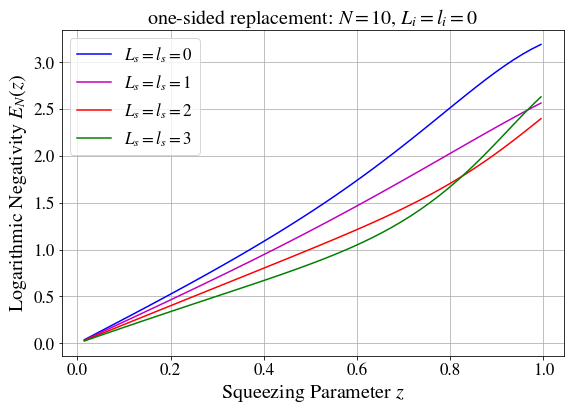

Time of Execution: 464.5974631309509 seconds


In [ ]:
#LogNeg-Test, lineout E_N(z)
Time=time.time()
plt.rcParams.update({'font.size': 17, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

N=10
T=0.9
steps=49
lim1=0.015
lim2=0.995
u=3 #1: sub, 2: add, 3: rep
v=1 #1: one-sided, 2: symmetrical

Ls=0
Li=Ls
ls=0
li=ls
ll=0

z=np.linspace(lim1,lim2,steps+1) #0.049,0.999 #0.099,0.999 #0.05,0.95
y=[]
c=['b','m','r','g']

fig=plt.figure(figsize=(9,6))

for l in range(4):
    if v==1: #one-sided
        if u==1:
            y.append(ArrayAN(LogNeg,State,z,T,N,Ls,Li,l,li)) #sub
            plt.plot(z, y[l], color=c[l], label='$l_{s}=$'+str(l))
        elif u==2:
            y.append(ArrayAN(LogNeg,State,z,T,N,l,Li,ls,li)) #add
            plt.plot(z, y[l], color=c[l], label='$L_{s}=$'+str(l))
        else:
            y.append(ArrayAN(LogNeg,State,z,T,N,l,Li,l,li)) #rep
            plt.plot(z, y[l], color=c[l], label='$L_{s}=l_{s}=$'+str(l))
    if v==2: #symmetrical
        if u==1:
            y.append(ArrayAN(LogNeg,State,z,T,N,Ls,Li,l,l)) #sub
            plt.plot(z, y[l], color=c[l], label='$l=$'+str(l))
        elif u==2:
            y.append(ArrayAN(LogNeg,State,z,T,N,l,l,ls,li)) #add
            plt.plot(z, y[l], color=c[l], label='$L=$'+str(l))
        else:
            y.append(ArrayAN(LogNeg,State,z,T,N,l,l,l,l)) #rep
            plt.plot(z, y[l], color=c[l], label='$L=l=$'+str(l))

plt.xlabel('Squeezing Parameter $z$', fontsize=20)
plt.ylabel('Logarithmic Negativity $E_{N}(z)$', fontsize=20)
plt.grid(True)
plt.legend(loc=0)

if v==1:
    if u==1:
        plt.title("one-sided subtraction: $N=$"+str(N)+", $L=$"+str(Ls)+", $l_{i}=$"+str(li), fontsize=20)
        plt.savefig("LogNeg_N"+str(N)+"_Ls"+str(Ls)+"_step"+str(steps)+"_u"+str(u)+"_v"+str(v)+"_osub.pdf", bbox_inches='tight')
    elif u==2:
        plt.title("one-sided addition: $N=$"+str(N)+", $l=$"+str(ls)+", $L_{i}=$"+str(Li), fontsize=20)
        plt.savefig("LogNeg_N"+str(N)+"_ls"+str(ls)+"_step"+str(steps)+"_u"+str(u)+"_v"+str(v)+"_oadd.pdf", bbox_inches='tight')
    else:
        plt.title("one-sided replacement: $N=$"+str(N)+", $L_{i}=l_{i}=$"+str(li), fontsize=20)
        plt.savefig("LogNeg_N"+str(N)+"_step"+str(steps)+"_u"+str(u)+"_v"+str(v)+"_orep.pdf", bbox_inches='tight')
else:
    if u==1:
        plt.title("Subtraction: $N=$"+str(N)+", $L=$"+str(Ls), fontsize=20)
        plt.savefig("LogNeg_N"+str(N)+"_L"+str(Ls)+"_step"+str(steps)+"_u"+str(u)+"_v"+str(v)+"_ssub.pdf", bbox_inches='tight')
    elif u==2:
        plt.title("Addition: $N=$"+str(N)+", $l=$"+str(ls), fontsize=20)
        plt.savefig("LogNeg_N"+str(N)+"_l"+str(ls)+"_step"+str(steps)+"_u"+str(u)+"_v"+str(v)+"_sadd.pdf", bbox_inches='tight')
    else:
        plt.title("Replacement: $N=$"+str(N), fontsize=20)
        plt.savefig("LogNeg_N"+str(N)+"_step"+str(steps)+"_u"+str(u)+"_v"+str(v)+"_srep.pdf", bbox_inches='tight')
plt.show()

print("Time of Execution:",time.time()-Time,"seconds")

0.098
0.198
0.298
0.398
0.498
0.598
0.698
0.798
0.898
0.998


0.098
0.198
0.298
0.398
0.498
0.598
0.698
0.798
0.898
0.998


0.098
0.198
0.298
0.398
0.498
0.598
0.698
0.798
0.898
0.998


0.098
0.198
0.298
0.398
0.498
0.598
0.698
0.798
0.898
0.998


0.098
0.198
0.298
0.398
0.498
0.598
0.698
0.798
0.898
0.998


Time of Execution: 1713.5642631053925 seconds


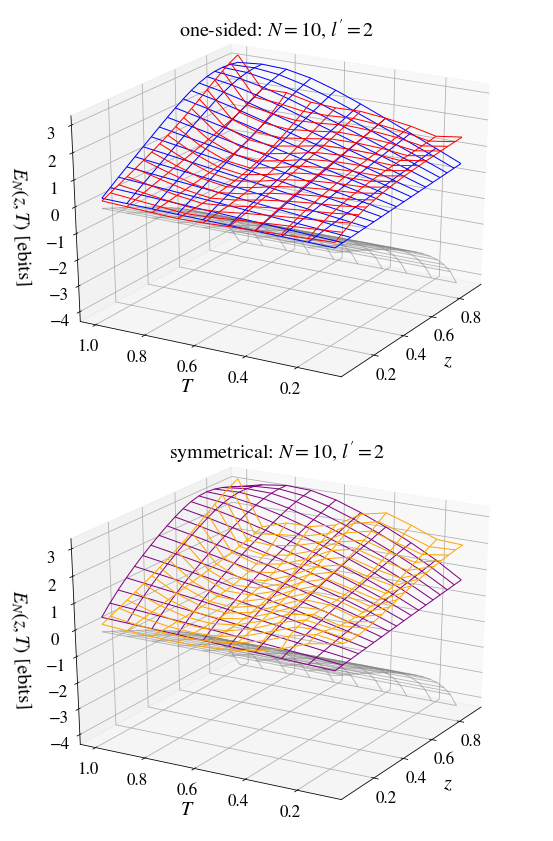

In [ ]:
#LogNeg (& Co.) Test, w/ variation of T -> TJB
#3D-plot of E_N(z,T)
Time=time.time()
plt.rcParams.update({'font.size': 17, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

def ArrayRef(z,T):
    y=[]
    for TT in T:
        yy=[]
        for zz in z:
            #p=math.log2((1+zz)/(1-zz))
            p=LNRef(zz)
            yy.append(p)
        y.append(yy)
        print(TT)
    print("\n")
    return np.array(y)


N=10
#T=0.9
stepsz=17
stepsT=9
limz1=0.049
limz2=0.899
limT1=0.098
limT2=0.998
d=0 #LogNeg!
ll=2
#Ls=0
#Li=Ls
#ls=0
#li=ls
#y=[]
#c=['b','m','r','g']

z=np.linspace(limz1,limz2,stepsz+1) #0.049,0.999 #0.099,0.999 #0.05,0.95
T=np.linspace(limT1,limT2,stepsT+1)
_z,_T=np.meshgrid(z, T)

yref=ArrayRef(z,T)
#yinit=ArrayAN2(LogNeg,State,z,T,N,0,0,0,0,d)
##single-mode op
ysub=ArrayAN2(LogNeg,State,z,T,N,0,0,ll,0,d)
#yadd=ArrayAN2(LogNeg,State,z,T,N,ll,0,0,0,d)
yrep=ArrayAN2(LogNeg,State,z,T,N,ll,0,ll,0,d)
##symmetrical op
ysub2=ArrayAN2(LogNeg,State,z,T,N,0,0,ll,ll,d)
#yadd2=ArrayAN2(LogNeg,State,z,T,N,ll,ll,0,0,d)
yrep2=ArrayAN2(LogNeg,State,z,T,N,ll,ll,ll,ll,d)

fig=plt.figure(figsize=(8,12)) #(12, 6) #(20,8)

#one-sided
ax=fig.add_subplot(2,1,1, projection='3d')

ax.plot_wireframe(_z, _T, yref, lw=1, label="Ref", color="grey", alpha=0.5) #color=c[l] #rstride=100, cstride=100,
#ax.plot_wireframe(_z, _T, yinit, lw=1, label="Init", color="orange", alpha=1.0) #color=c[l]

ax.plot_wireframe(_z, _T, ysub, lw=1, label="Sub", color="blue", alpha=1.0) #color=c[l] #shade=True
#ax.plot_wireframe(_z, _T, yadd, lw=1, label="Add", color="green", alpha=1.0) #color=c[l] #rcount=50, ccount=50,
ax.plot_wireframe(_z, _T, yrep, lw=1, label="Rep", color="red", alpha=1.0) #color=c[l]

ax.set_xlabel('$z$', fontsize=20) #Squeezing Parameter
ax.set_ylabel('$T$', fontsize=20) #Transmittivity
ax.set_zlabel('$E_{N}(z,T)$ [ebits]', fontsize=20) #Logarithmic Negativity
ax.xaxis.labelpad=10
ax.yaxis.labelpad=10
ax.zaxis.labelpad=10
ax.set_title("one-sided: $N=$"+str(N)+", $l'=$"+str(ll), fontsize=20)
ax.grid(True)
#ax.legend(loc=0)
ax.view_init(25, 210)


#symmetrical
ax=fig.add_subplot(2,1,2, projection='3d')

ax.plot_wireframe(_z, _T, yref, lw=1, label="Ref", color="grey", alpha=0.5) #color=c[l] #rstride=100, cstride=100,
#ax.plot_wireframe(_z, _T, yinit, lw=1, label="Init", color="orange", alpha=1.0) #color=c[l]

ax.plot_wireframe(_z, _T, ysub2, lw=1, label="Sub2", color="purple", alpha=1.0) #color=c[l] #shade=True
#ax.plot_wireframe(_z, _T, yadd2, lw=1, label="Add2", color="green", alpha=1.0) #color=c[l] #rcount=50, ccount=50,
ax.plot_wireframe(_z, _T, yrep2, lw=1, label="Rep2", color="orange", alpha=1.0) #color=c[l]

ax.set_xlabel('$z$', fontsize=20) #Squeezing Parameter
ax.set_ylabel('$T$', fontsize=20) #Transmittivity
ax.set_zlabel('$E_{N}(z,T)$ [ebits]', fontsize=20) #Logarithmic Negativity
ax.xaxis.labelpad=10
ax.yaxis.labelpad=10
ax.zaxis.labelpad=10
ax.set_title("symmetrical: $N=$"+str(N)+", $l'=$"+str(ll), fontsize=20)
ax.grid(True)
#ax.legend(loc=0)
ax.view_init(25, 210)

fig.tight_layout()
fig.savefig("LogNeg3d_N"+str(N)+"_Ll"+str(ll)+"_stepz"+str(stepsz)+"_stepT"+str(stepsT)+".pdf", bbox_inches='tight') #all for ll
#fig.show()

print("Time of Execution:",time.time()-Time,"seconds")

0.095
0.195
0.295
0.395
0.495
0.595
0.695
0.795
0.895
0.995


0.095
0.195
0.295
0.395
0.495
0.595
0.695
0.795
0.895
0.995


0.095
0.195
0.295
0.395
0.495
0.595
0.695
0.795
0.895
0.995


0.095
0.195
0.295
0.395
0.495
0.595
0.695
0.795
0.895
0.995


Time of Execution: 1699.7265057563782 seconds


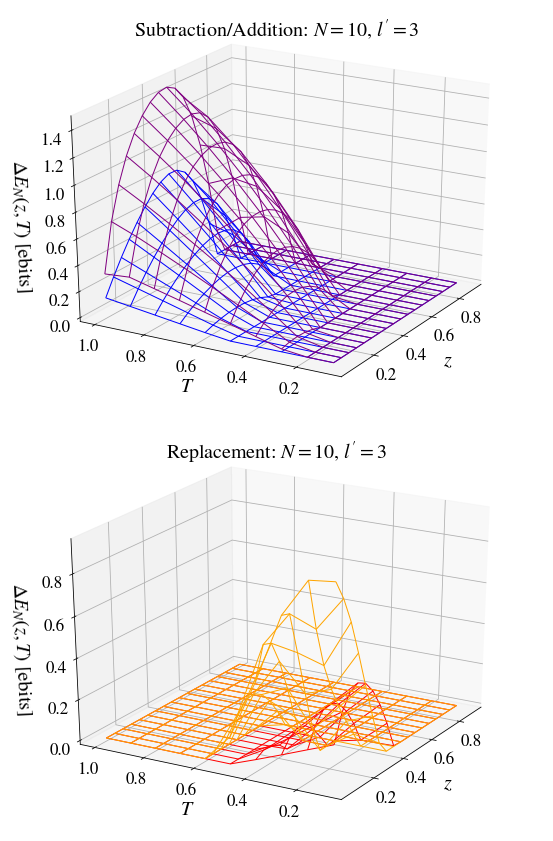

In [ ]:
#Difference \Delta E_N(z,T)
#3D-Plot for z & T
Time=time.time()
plt.rcParams.update({'font.size': 17, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

N=10
#T=0.9
stepsz=17
stepsT=9
fac=2#*math.sqrt(2)
limz1=0.049
limz2=0.899
limT1=0.095
limT2=0.995
d=1 #Difference!
ll=3

z=np.linspace(limz1,limz2,stepsz+1) #0.049,0.999 #0.099,0.999 #0.05,0.95
T=np.linspace(limT1,limT2,stepsT+1)
_z,_T=np.meshgrid(z, T)

#yref=ArrayRef(z,T)
#yinit=ArrayAN2(LogNeg,State,z,T,N,0,0,0,0,d)
##single-mode op
ysub=ArrayAN2(LogNeg,State,z,T,N,0,0,ll,0,d) #math.sqrt(2)
#yadd=ArrayAN2(LogNeg,State,z,T,N,ll,0,0,0,d)
yrep=ArrayAN2(LogNeg,State,z,T,N,ll,0,ll,0,d) #2*math.sqrt(2)
##symmetrical op
ysub2=ArrayAN2(LogNeg,State,z,T,N,0,0,ll,ll,d)
#yadd2=ArrayAN2(LogNeg,State,z,T,N,ll,ll,0,0,d)
yrep2=ArrayAN2(LogNeg,State,z,T,N,ll,ll,ll,ll,d)

fig=plt.figure(figsize=(8,12))
#sub/add
ax=fig.add_subplot(2,1,1, projection='3d')

#ax.plot_wireframe(_z, _T, yref, lw=1, label="Ref", color="grey", alpha=0.5) #color=c[l] #rstride=100, cstride=100,
#ax.plot_wireframe(_z, _T, yinit, lw=1, label="Init", color="orange", alpha=1.0) #color=c[l]

ax.plot_wireframe(_z, _T, ysub, lw=1, label="Sub", color="blue", alpha=1.0) #color=c[l] #shade=True
#ax.plot_wireframe(_z, _T, yadd, lw=1, label="Add", color="green", alpha=1.0) #color=c[l] #rcount=50, ccount=50,
#ax.plot_wireframe(_z, _T, yrep, lw=1, label="Rep", color="red", alpha=1.0) #color=c[l]

ax.plot_wireframe(_z, _T, ysub2, lw=1, label="Sub2", color="purple", alpha=1.0) #color=c[l] #shade=True
#ax.plot_wireframe(_z, _T, yadd2, lw=1, label="Add2", color="green", alpha=1.0) #color=c[l] #rcount=50, ccount=50,
#ax.plot_wireframe(_z, _T, yrep2, lw=1, label="Rep2", color="orange", alpha=1.0) #color=c[l]

ax.set_xlabel('$z$', fontsize=20) #Squeezing Parameter
ax.set_ylabel('$T$', fontsize=20) #Transmittivity
ax.set_zlabel(r'$\Delta E_{N}(z,T)$ [ebits]', fontsize=20) #Logarithmic Negativity
ax.xaxis.labelpad=10
ax.yaxis.labelpad=10
ax.zaxis.labelpad=10
ax.set_title("Subtraction/Addition: $N=$"+str(N)+", $l'=$"+str(ll), fontsize=20)
ax.grid(True)
#ax.legend(loc=0)
ax.view_init(25, 210) #(40, 210) #(0, 50) #(24, 215)


#repl
ax=fig.add_subplot(2,1,2, projection='3d')

#ax.plot_wireframe(_z, _T, yref, lw=1, label="Ref", color="grey", alpha=0.5) #color=c[l] #rstride=100, cstride=100,
#ax.plot_wireframe(_z, _T, yinit, lw=1, label="Init", color="orange", alpha=1.0) #color=c[l]

#ax.plot_wireframe(_z, _T, ysub, lw=1, label="Sub", color="blue", alpha=1.0) #color=c[l] #shade=True
#ax.plot_wireframe(_z, _T, yadd, lw=1, label="Add", color="green", alpha=1.0) #color=c[l] #rcount=50, ccount=50,
ax.plot_wireframe(_z, _T, yrep, lw=1, label="Rep", color="red", alpha=1.0) #color=c[l]

#ax.plot_wireframe(_z, _T, ysub2, lw=1, label="Sub2", color="purple", alpha=1.0) #color=c[l] #shade=True
#ax.plot_wireframe(_z, _T, yadd2, lw=1, label="Add2", color="green", alpha=1.0) #color=c[l] #rcount=50, ccount=50,
ax.plot_wireframe(_z, _T, yrep2, lw=1, label="Rep2", color="orange", alpha=1.0) #color=c[l]

ax.set_xlabel('$z$', fontsize=20) #Squeezing Parameter
ax.set_ylabel('$T$', fontsize=20) #Transmittivity
ax.set_zlabel(r'$\Delta E_{N}(z,T)$ [ebits]', fontsize=20) #Logarithmic Negativity
ax.xaxis.labelpad=10
ax.yaxis.labelpad=10
ax.zaxis.labelpad=10
ax.set_title("Replacement: $N=$"+str(N)+", $l'=$"+str(ll), fontsize=20)
ax.grid(True)
#ax.legend(loc=0)
ax.view_init(25, 210)

fig.tight_layout()
fig.savefig("Diff3d_N"+str(N)+"_Ll"+str(ll)+"_stepz"+str(stepsz)+"_stepT"+str(stepsT)+".pdf", bbox_inches='tight') #all for ll
#fig.show()

print("Time of Execution:",time.time()-Time,"seconds")

In [ ]:
#LogNeg (& Co.) Test, w/ variation of T -> Bartley Paper
#2D-plot of E_N(T) at z=0.1
Time=time.time()
plt.rcParams.update({'font.size': 17, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

def ArrayLN(F,A,z,T,N,Ls,Li,ls,li): #for lineout of E_N for all non-Gaussian operations #(F,A,z,N,Ls,Li,ls,li)
    y=[]
    for TT in T: #run tru T
        y.append(F(A(z,TT,N,Ls,Li,ls,li), N))#-math.log2((1+z)/(1-z))
        print(TT)
    print("\n")
    return np.array(y)

def ArrayRef2(z,T): #for lineout of E_N for all non-Gaussian operations #(F,A,z,N,Ls,Li,ls,li)
    y=[]
    for TT in T: #run tru T
        #p=math.log2((1+z)/(1-z))
        p=LNRef(z)
        y.append(p)
        print(TT)
    print("\n")
    return np.array(y)

N=14
z=0.1
#T=0.9
#stepsz=8
stepsT=49
lim1=0.015
lim2=0.995
T = np.linspace(lim1,lim2,stepsT+1)
ll=2
#v=1 #1: one-sided, 2: symmetrical

yref=ArrayRef2(z,T)
#yinit=ArrayAN2(LogNeg,State,z,T,N,0,0,0,0)
##single-mode op
ysub=ArrayLN(LogNeg,State,z,T,N,0,0,ll,0)
#yadd=ArrayAN2(LogNeg,State,z,T,N,1,0,0,0)
yrep=ArrayLN(LogNeg,State,z,T,N,ll,0,ll,0)
##symmetrical op
ysub2=ArrayLN(LogNeg,State,z,T,N,0,0,ll,ll)
#yadd2=ArrayAN2(LogNeg,State,z,T,N,1,1,0,0)
yrep2=ArrayLN(LogNeg,State,z,T,N,ll,ll,ll,ll)

fig = plt.figure(figsize=(9,6)) #figsize=(16,5) #figsize=(20,7)
ax=fig.add_subplot(1,1,1)

ax.plot(T, yref, label="Ref", color="grey") #color=c[l]
#ax.plot(T, yinit, label="Init", color="black", alpha=1.0) #color=c[l]

ax.plot(T, ysub, label="Sub", color="blue") #color=c[l] #shade=True
#ax.plot(T, yadd, label="Add", color="yellow") #color=c[l] #rcount=50, ccount=50,
ax.plot(T, yrep, label="Rep", color="red") #color=c[l]

ax.plot(T, ysub2, label="Sub2", color="purple") #color=c[l] #shade=True
#ax.plot(T, yadd2, label="Add2", color="green") #color=c[l] #rcount=50, ccount=50,
ax.plot(T, yrep2, label="Rep2", color="orange") #color=c[l]

#ax.set_xlabel('$z$', fontsize=20) #Squeezing Parameter
ax.set_xlabel('Transmittivity $T$', fontsize=20) #Transmittivity
ax.set_ylabel('Logarithmic Negativity $E_{N}(T)$ [ebits]', fontsize=20) #Logarithmic Negativity
#ax.xaxis.labelpad=15
#ax.yaxis.labelpad=15
ax.set_title("Lineout: $z=$"+str(z)+", $N=$"+str(N)+", $l'=$"+str(ll), fontsize=20)
ax.grid(True)
#ax.legend(loc=0)
fig.savefig("LogNeg2d_N"+str(N)+"_ll"+str(ll)+"_stepT"+str(stepsT)+".pdf", bbox_inches='tight')
#fig.show()

print("Time of Execution:",time.time()-Time,"seconds")

0.015
0.035
0.055
0.075
0.095
0.115
0.135
0.155
0.175
0.195
0.215
0.235
0.255
0.275
0.295
0.315
0.335
0.355
0.375
0.395
0.415
0.435
0.455
0.475
0.495
0.515
0.535
0.555
0.575
0.595
0.615
0.635
0.655
0.675
0.695
0.715
0.735
0.755
0.775
0.795
0.815
0.835
0.855
0.875
0.895
0.915
0.935
0.955
0.975
0.995


0.015


State ExpV:	 0.6580996293949967
Prob Sum:	 1.0
Area Mean:	 1.2346200004355103
Plot Height:	 0.603100005675594 

State ExpV:	 2.2584072758754923
Prob Sum:	 1.0000000000000002
Area Mean:	 2.9286510011263696
Plot Height:	 0.24931261767643076 

State ExpV:	 3.9831345040109323
Prob Sum:	 1.0
Area Mean:	 4.651990764825755
Plot Height:	 0.18173522512708373 

State ExpV:	 5.691927906985888
Prob Sum:	 0.9999999999999999
Area Mean:	 6.35630028021068
Plot Height:	 0.1481515275296264 

Time of Execution: 197.6403615474701 seconds


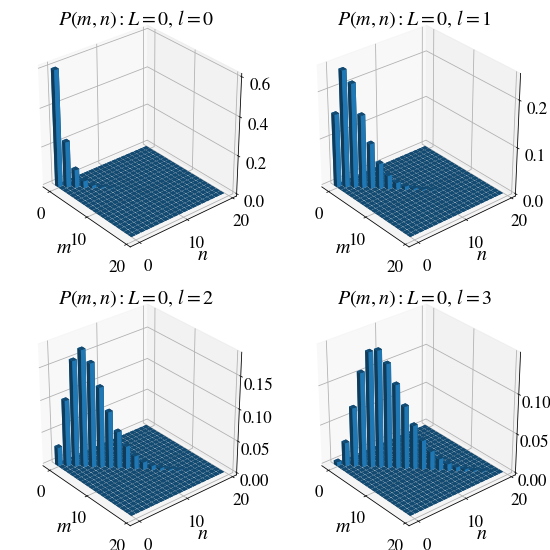

In [ ]:
#4-subplot-Output for joint photon number distributions (JPD), ideal and lossy
Time=time.time()
plt.rcParams.update({'font.size': 17, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

def ArrayProb(A,z,N,Ls,Li,ls,li,g):
    y=[]
    s=0
    q=0
    t=0
    tt=0
    for i in range(N):
        for k in range(N):
            if g==0:
                p=Prob1(A,z,N,Ls,Li,ls,li,i,k)
            else:
                p=MProb1(A,z,N,Ls,Li,ls,li,i,k)
            x=(i,k), p
            y.append(x)
            s=s+p
            q=q+p*i*k
            #if i==k:
            #    t=t+p*i
            #    tt=tt+p
            #else:
            #    pass
    print("Prob Sum:\t",s)
    print("Area Mean:\t",math.sqrt(q))
    #print("Diag Mean:\t",t/tt)
    return np.array(y)

N=7
z=0.66
Ls=0
Li=Ls
ls=0
li=ls
T=0.9
g=0 #0: Prob1, #1: MProb1

mean=[]
MM=[]
NN=[]
Y=[]
Yz=[]
ax=[]
w=0.9
v=w/2

fig = plt.figure(figsize=(8,8)) #figsize=(16,5) #figsize=(20,7)
cmap=cm.get_cmap('jet')

for l in range(4): #control variable l
    u=N#+l

    op=Mode(nop(u), 1)
    A=State(z,T,u,Ls,Li,l,l) #change photon operation here!
    mean.append(expect(op,A))
    print("State ExpV:\t",mean[l])

    _m=np.arange(u)
    _n=_m
    _mm,_nn=np.meshgrid(_m,_n)
    m=_mm.ravel()
    n=_nn.ravel()
    MM.append(m)
    NN.append(n)

    Y.append(ArrayProb(A,z,u,Ls,Li,l,l,g)) #change photon operation here!
    Yz.append(np.zeros_like(Y[l]))
    h=max(Y[l][:,-1])
    print("Plot Height:\t",h,"\n")

    ax.append(fig.add_subplot(2,2,l+1, projection='3d', aspect='equal')) #alpha=0.1
    ax[l].bar3d(MM[l]-v, NN[l]-v, Yz[l][:,1], w, w, Y[l][:,1], shade=True) #[:,1] #color=cc
    #ax[l].set_xticks(MM[l])
    #ax[l].set_yticks(NN[l])
    ax[l].set_xlabel("$m$", fontsize=20)
    ax[l].set_ylabel("$n$", fontsize=20)
    ax[l].set_title("$P(m,n): L=$"+str(Ls)+", $l=$"+str(l), fontsize=20) #change photon operation here!
    ax[l].grid(True)
    if g==0:
        ax[l].view_init(30, -40) #view for Prob1
    else:
        ax[l].view_init(30, 45) #view for MProb1

fig.tight_layout()

#change save-file here!
fig.savefig("Prob_z"+str(z)+"_L"+str(Ls)+"_N"+str(N)+"_sub.pdf", bbox_inches='tight') #, pad_inches=0.3
#fig.savefig("Prob_z"+str(z)+"_l"+str(ls)+"_N"+str(N)+"_add.pdf", bbox_inches='tight') #, pad_inches=0.3
#fig.savefig("Prob_z"+str(z)+"_Ll_N"+str(N)+"_rep.pdf", bbox_inches='tight') #, pad_inches=0.3
#fig.savefig("MProb_z"+str(z)+"_L"+str(Ls)+"_N"+str(N)+"_sub.pdf", bbox_inches='tight') #, pad_inches=0.3
#fig.savefig("MProb_z"+str(z)+"_l"+str(ls)+"_N"+str(N)+"_add.pdf", bbox_inches='tight') #, pad_inches=0.3
#fig.savefig("MProb_z"+str(z)+"_Ll_N"+str(N)+"_rep.pdf", bbox_inches='tight') #, pad_inches=0.3

print("Time of Execution:",time.time()-Time,"seconds")

1 / 16
State ExpV:	 0.5404346354173286
Prob Sum:	 1.0
Area Mean:	 1.0493406259873623
Plot Height:	 0.64760487994354 

2 / 16
State ExpV:	 1.0374633252312884
Prob Sum:	 1.0
Area Mean:	 1.8727239555060928
Plot Height:	 0.4228047213208501 

3 / 16
State ExpV:	 1.380452039347538
Prob Sum:	 0.9999999999999999
Area Mean:	 2.47613250628855
Plot Height:	 0.30441363808540034 

4 / 16
State ExpV:	 1.441467007862661
Prob Sum:	 1.0
Area Mean:	 2.7344637355159507
Plot Height:	 0.31122585166599787 

5 / 16
State ExpV:	 0.5404346354173286
Prob Sum:	 1.0000000000000002
Area Mean:	 1.8727239555060928
Plot Height:	 0.42280472132085023 

6 / 16
State ExpV:	 1.0374633252312884
Prob Sum:	 0.9999999999999999
Area Mean:	 0.7927112952074432
Plot Height:	 0.7247976926268461 

7 / 16
State ExpV:	 1.380452039347538
Prob Sum:	 0.9999999999999998
Area Mean:	 1.6782837259007852
Plot Height:	 0.4738111464071495 

8 / 16
State ExpV:	 1.441467007862661
Prob Sum:	 0.9999999999999999
Area Mean:	 2.3496320355681095
Plot 

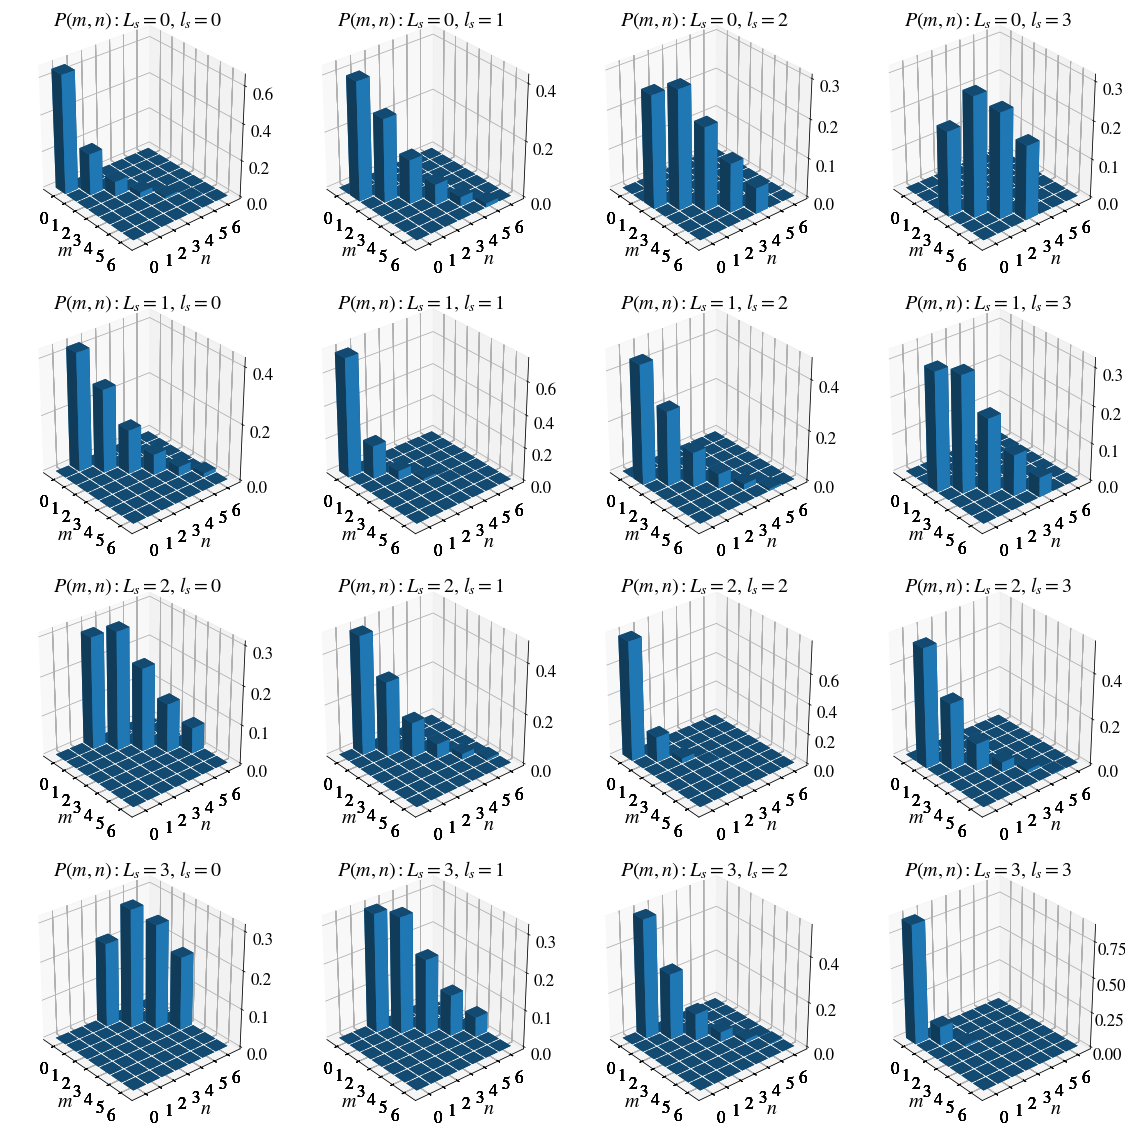

In [ ]:
#16-subplot-Output for joint photon number distributions (JPD), ideal and lossy
Time=time.time()
plt.rcParams.update({'font.size': 17, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

N=7
z=0.66
Ls=0
Li=Ls
ls=0
li=ls
T=0.9
g=0 #0: Prob1, #1: MProb1
f=1 #1: one-sided, 2: symmetrical

mean=[]
MM=[]
NN=[]
Y=[]
Yz=[]
ax=[]
w=0.9
v=w/2
cc=0

fig = plt.figure(figsize=(16,16))

for L in range(4):
    Y.append([])
    Yz.append([])
    ax.append([])
    MM.append([])
    NN.append([])
    for l in range(4):
        u=N#+l
        cc=cc+1
        print(cc,"/ 16")

        op=Mode(nop(u), 1)
        if f==1:
            A=State(z,T,u,L,0,l,0)
        else:
            A=State(z,T,u,L,L,l,l)
        mean.append(expect(op,A))
        print("State ExpV:\t",mean[l])

        _m=np.arange(u)
        _n=_m
        _mm,_nn=np.meshgrid(_m,_n)
        m=_mm.ravel()
        n=_nn.ravel()
        MM[L].append(m)
        NN[L].append(n)

        if f==1:
            Y[L].append(ArrayProb(A,z,u,L,0,l,0,g))
        else:
            Y[L].append(ArrayProb(A,z,u,L,L,l,l,g))
        Yz[L].append(np.zeros_like(Y[L][l]))
        h=max(Y[L][l][:,-1])
        print("Plot Height:\t",h,"\n")

        ax[L].append(fig.add_subplot(4,4,cc, projection='3d', aspect='equal')) #alpha=0.1
        ax[L][l].bar3d(MM[L][l]-v, NN[L][l]-v, Yz[L][l][:,1], w, w, Y[L][l][:,1], shade=True) #[:,1] #color=cc
        ax[L][l].set_xticks(MM[L][l])
        ax[L][l].set_yticks(NN[L][l])
        ax[L][l].set_xlabel("$m$", fontsize=20)
        ax[L][l].set_ylabel("$n$", fontsize=20)
        ax[L][l].grid(True)

        if g==0:
            ax[L][l].view_init(30, -40)
            if f==1:
                ax[L][l].set_title("$P(m,n): L_{s}=$"+str(L)+", $l_{s}=$"+str(l), fontsize=20)
            else:
                ax[L][l].set_title("$P(m,n): L=$"+str(L)+", $l=$"+str(l), fontsize=20)
        else:
            ax[L][l].view_init(30, 45)
            if f==1:
                ax[L][l].set_title(r"$P'(m,n,\eta,}nu): L=$"+str(L)+", $l=$"+str(l), fontsize=20)
            else:
                ax[L][l].set_title(r"$P'(m,n,\eta,\nu): L=$"+str(L)+", $l=$"+str(l), fontsize=20)
fig.tight_layout()

if g==0:
    if f==1:
        fig.savefig("Prob_z"+str(z)+"_N"+str(N)+"_o16.pdf", bbox_inches='tight')
    else:
        fig.savefig("Prob_z"+str(z)+"_N"+str(N)+"_s16.pdf", bbox_inches='tight')
else:
    if f==1:
        fig.savefig("MProb_z"+str(z)+"_N"+str(N)+"_o16.pdf", bbox_inches='tight')
    else:
        fig.savefig("MProb_z"+str(z)+"_N"+str(N)+"_s16.pdf", bbox_inches='tight')

print("Time of Execution:",time.time()-Time,"seconds")

0.019
0.039
0.059
0.079
0.099
0.119
0.139
0.159
0.179
0.199
0.219
0.239
0.259
0.279
0.299
0.319
0.339
0.359
0.379
0.399
0.419
0.439
0.459
0.479
0.499
0.519
0.539
0.559
0.579
0.599
0.619
0.639
0.659
0.679
0.699
0.719
0.739
0.759
0.779
0.799
0.819
0.839
0.859
0.879
0.899
0.919
0.939
0.959
0.979
0.999


0.019
0.039
0.059
0.079
0.099
0.119
0.139
0.159
0.179
0.199
0.219
0.239
0.259
0.279
0.299
0.319
0.339
0.359
0.379
0.399
0.419
0.439
0.459
0.479
0.499
0.519
0.539
0.559
0.579
0.599
0.619
0.639
0.659
0.679
0.699
0.719
0.739
0.759
0.779
0.799
0.819
0.839
0.859
0.879
0.899
0.919
0.939
0.959
0.979
0.999


0.019
0.039
0.059
0.079
0.099
0.119
0.139
0.159
0.179
0.199
0.219
0.239
0.259
0.279
0.299
0.319
0.339
0.359
0.379
0.399
0.419
0.439
0.459
0.479
0.499
0.519
0.539
0.559
0.579
0.599
0.619
0.639
0.659
0.679
0.699
0.719
0.739
0.759
0.779
0.799
0.819
0.839
0.859
0.879
0.899
0.919
0.939
0.959
0.979
0.999


0.019
0.039
0.059
0.079
0.099
0.119
0.139
0.159
0.179
0.199
0.219
0.239
0.259
0.279
0.299
0.31

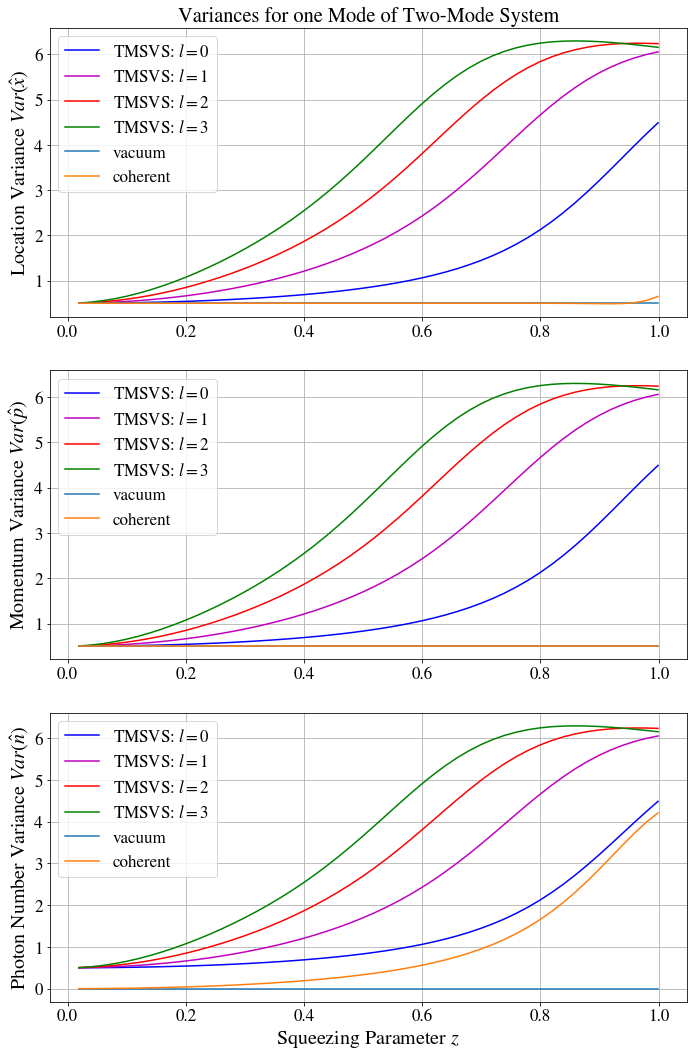

In [ ]:
#------------------------------------------------#
#Two-Mode System, for symmetrical subtraction only
#------------------------------------------------#
Time=time.time()
plt.rcParams.update({'font.size': 17, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

z=0.66
N=10
l=3

#SPDC-type2-squeezed vacuum state w/ ladder-ops
def squeeze1(z,N,l):
    s=tensor(null(N),null(N))
    for n in range(N):
        s=s+(z**n)*tensor(basis(N,n), basis(N,n))
    s=s.unit()
    return s


#SPDC-type2-squeezed vacuum state, l-subtracted, numeric
#norm of B
def NB(z,N,l):
    out=0
    for j in range(l,N+l):
        out=out+(Q(z)**j)*((fak(j)/fak(j-l))**2)
    return out

#pre-factor B
def BB(z,N,l,j):
    #return cmath.sqrt(NB(z,N,l))*(z**j)*fak(j)/fak(j-l)
    return (z**j)*fak(j)/fak(j-l)

#l-subtracted squeezed-state 2
def sub2(z,N,l):
    S=tensor(null(N), null(N))
    for j in range(l,N+l):
        S=S+BB(z,N,l,j)*tensor(basis(N,j-l), basis(N,j-l))
        #S=S+BB(z,N,l,j)*tensor(basis(N,j-l),basis(N,j-l))/math.sqrt(NB(z,N,l))
    S=S.unit()
    return S

#Custom Arraymaker for one mode out of 2-mode system
def ArrayS(op,AAA,z,N,l): #(F,A,z,N,Ls,Li,ls,li) #(F,z,N,Ls,Li,ls,li)
    y=[]
    for zz in z:
        B=(AAA(zz,N,l).ptrace(0)).unit()
        y.append(variance(op(N), B))
        print(zz)
    print("\n")
    return np.array(y)

def vac2(z,N,l):
    return fock(N,0)

def coh2(z,N,l):
    op=nop(N)
    C=(squeeze1(z,N,l).ptrace(0)).unit()
    h=math.sqrt(expect(op, C))
    return coherent(N, h)

#Plot variances!
lim1=0.019
lim2=0.999
steps=49
c=['b','m','r','g']
z=np.linspace(lim1,lim2,steps+1)
y=[]

fig, ax=plt.subplots(3,1, figsize=(10,15))
for l in range(4):
    y.append(ArrayS(X,sub2,z,N,l))
    ax[0].plot(z, np.array(y[l]), label="TMSVS: $l=$"+str(l), color=c[l])
ax[0].plot(z, np.array(ArrayS(X,vac2,z,N,l)), label="vacuum")
ax[0].plot(z, np.array(ArrayS(X,coh2,z,N,l)), label="coherent")
#ax[0].set_xlabel(r'Squeezing Parameter $z$', fontsize=20)
ax[0].set_ylabel(r'Location Variance $Var(\hat{x})$', fontsize=20)
ax[0].grid(True)
ax[0].legend(loc=0)
ax[0].set_title("Variances for one Mode of Two-Mode System")

for l in range(4):
    y.append(ArrayS(P,sub2,z,N,l))
    ax[1].plot(z, np.array(y[l]), label="TMSVS: $l=$"+str(l), color=c[l])
ax[1].plot(z, np.array(ArrayS(P,vac2,z,N,l)), label="vacuum")
ax[1].plot(z, np.array(ArrayS(P,coh2,z,N,l)), label="coherent")
#ax[1].set_xlabel(r'Squeezing Parameter $z$', fontsize=20)
ax[1].set_ylabel(r'Momentum Variance $Var(\hat{p})$', fontsize=20)
ax[1].grid(True)
ax[1].legend(loc=0)
#ax[0].title("$N=$"+str(N)+", $l=$"+str(l), fontsize=20) #l_{-}
#ax[0].set_title("Variances for one Mode of Two-Mode System")

for l in range(4):
    y.append(ArrayS(nop,sub2,z,N,l))
    ax[2].plot(z, np.array(y[l]), label="TMSVS: $l=$"+str(l), color=c[l])
ax[2].plot(z, np.array(ArrayS(nop,vac2,z,N,l)), label="vacuum")
ax[2].plot(z, np.array(ArrayS(nop,coh2,z,N,l)), label="coherent")
ax[2].set_xlabel(r'Squeezing Parameter $z$', fontsize=20)
ax[2].set_ylabel(r'Photon Number Variance $Var(\hat{n})$', fontsize=20)
ax[2].grid(True)
ax[2].legend(loc=0)

fig.tight_layout()
fig.savefig("Variances_N"+str(N)+"_step"+str(steps)+"_2mode.pdf")
#plt.show()

print("Time of Execution:",time.time()-Time,"seconds")

0.9999999999999998
0.9607842984848345 

0.9999999999999999
3.211209471993415 

1.0
5.566382911352284 

1.0000000000000002
7.9060852060553835 

Time of Execution: 15.959719896316528 seconds


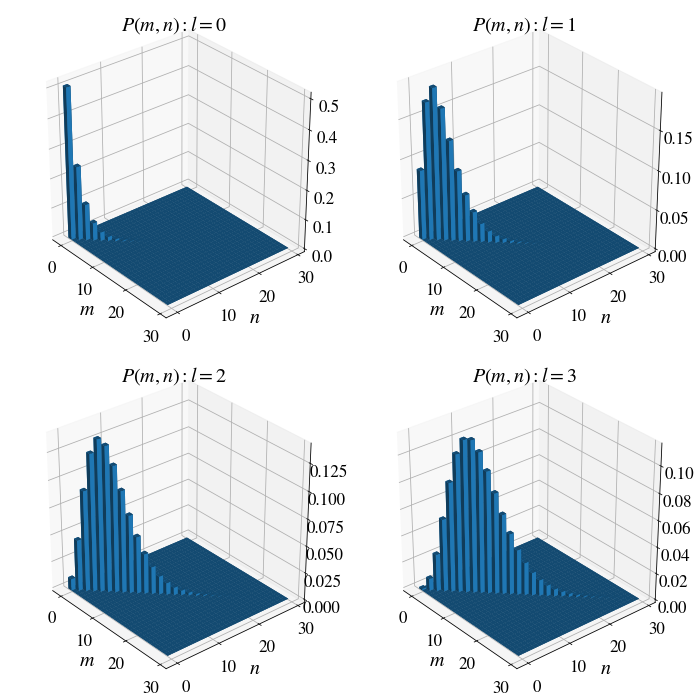

In [ ]:
Time=time.time()
plt.rcParams.update({'font.size': 17, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

#Prob for 2-mode State, ideal
def SProb(A,z,N,l,m,n):
    Op=tensor(fock_dm(N,m), fock_dm(N,n))
    s=expect(Op,A)
    return s

#Prob for 2-mode State, lossy
def SMProb(A,z,N,l,m,n,seta,sny):
    eff=seta*nop(N)+sny
    effe=(-eff).expm()
    Op=tensor((eff**m)*effe/fak(m), (eff**n)*effe/fak(n))
    s=expect(Op,A)
    return s

def ArrayProbS(A,z,N,l,seta,sny,v):
    y=[]
    S=0
    for i in range(N):
        for k in range(N):
            if v==0:
                p=SProb(A,z,N,l,i,k) #ideal
            else:
                p=SMProb(A,z,N,l,i,k,seta,sny) #lossy
            x=(i,k), p
            y.append(x)
            S=S+p
    print(S)
    return np.array(y)

N=30
z=0.7
steps=20
seta=0.3 #loss parameters
sny=0.4
v=0 #0: DetMom(SMProb);, 1: DetMom3(SProb)
mean=[]
MM=[]
NN=[]
Y=[]
Yz=[]
ax=[]
vac=tensor(basis(N,0), basis(N,0))

fig = plt.figure(figsize=(10,10)) #(16,5) #(20,6)
for l in range(4):
    u=N#+l #u=N

    op=tensor(nop(u), qeye(u))
    A=sub2(z,N,l)
    mean.append(expect(op,A))

    _m=np.arange(u)
    _n=_m
    _mm,_nn=np.meshgrid(_m,_n)
    m,n=_mm.ravel(), _nn.ravel()
    MM.append(m)
    NN.append(n)

    Y.append(ArrayProbS(A,z,u,l,seta,sny,v))
    Yz.append(np.zeros_like(Y[l]))
    print(mean[l],"\n")

    ax.append(fig.add_subplot(2,2,l+1, projection='3d'))
    ax[l].bar3d(MM[l]-0.5, NN[l]-0.5, Yz[l][:,1], 1, 1, Y[l][:,1], shade=True) #[:,1]
    #ax[l].set_xticks(MM[l])
    #ax[l].set_yticks(NN[l])
    ax[l].set_xlabel("$m$", fontsize=20)
    ax[l].set_ylabel("$n$", fontsize=20)
    if v==0:
        ax[l].set_title("$P(m,n): l=$"+str(l), fontsize=20)
    else:
        ax[l].set_title(r"$P'(m,n,\eta,\nu): l=$"+str(l), fontsize=20)
    ax[l].view_init(30, -40) #(30, 45) #(20, 15) #(50, -40)

fig.tight_layout()
if v==0:
    fig.savefig("SProb_N"+str(N)+"_l"+str(l)+".pdf", bbox_inches='tight') #pad_inches=0.3
else:
    fig.savefig("SMProb_N"+str(N)+"_l"+str(l)+"_eta"+str(seta)+"_ny"+str(sny)+".pdf", bbox_inches='tight')

print("Time of Execution:",time.time()-Time,"seconds")

0.009
0.019
0.029
0.039
0.049
0.059
0.069
0.079
0.089
0.099
0.109
0.119
0.129
0.139
0.149
0.159
0.169
0.179
0.189
0.199
0.209
0.219
0.229
0.239
0.249
0.259
0.269
0.279
0.289
0.299
0.309
0.319
0.329
0.339
0.349
0.359
0.369
0.379
0.389
0.399
0.409
0.419
0.429
0.439
0.449
0.459
0.469
0.479
0.489
0.499
0.509
0.519
0.529
0.539
0.549
0.559
0.569
0.579
0.589
0.599
0.609
0.619
0.629
0.639
0.649
0.659
0.669
0.679
0.689
0.699
0.709
0.719
0.729
0.739
0.749
0.759
0.769
0.779
0.789
0.799
0.809
0.819
0.829
0.839
0.849
0.859
0.869
0.879
0.889
0.899
0.909
0.919
0.929
0.939
0.949
0.959
0.969
0.979
0.989
0.999


0.009
0.019
0.029
0.039
0.049
0.059
0.069
0.079
0.089
0.099
0.109
0.119
0.129
0.139
0.149
0.159
0.169
0.179
0.189
0.199
0.209
0.219
0.229
0.239
0.249
0.259
0.269
0.279
0.289
0.299
0.309
0.319
0.329
0.339
0.349
0.359
0.369
0.379
0.389
0.399
0.409
0.419
0.429
0.439
0.449
0.459
0.469
0.479
0.489
0.499
0.509
0.519
0.529
0.539
0.549
0.559
0.569
0.579
0.589
0.599
0.609
0.619
0.629
0.639
0.649
0.659
0.

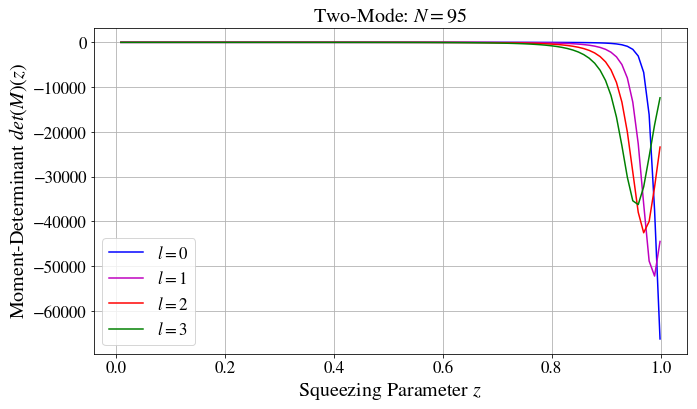

Time of Execution: 45.18064570426941 seconds


In [15]:
Time=time.time()
plt.rcParams.update({'font.size': 17, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

#DetMom-Test for 2-Mode State
def ArraySDM(z,N,l,seta,sny,v): #(F,A,z,N,Ls,Li,ls,li) #(F,z,N,Ls,Li,ls,li)
    y=[]
    for zz in z:
        if v==0:
            y.append(SDetMom3(zz,N,l,seta,sny)) #ideal
        else:
            y.append(SDetMom(zz,N,l,seta,sny)) #lossy
        print(zz)
    print("\n")
    return np.array(y)

def SDetMom(z,N,l,seta,sny):
    A=sub2(z,N,l)
    ms=mi=ms2=mi2=msi=0
    for m in range(N):
        for n in range(N):
            p=SMProb(A,z,N,l,m,n,seta,sny)
            ms=ms+m*p
            mi=mi+n*p
            ms2=ms2+m*(m-1)*p
            mi2=mi2+n*(n-1)*p
            msi=msi+m*n*p
    S=(ms2-ms**2)*(mi2-mi**2)-(msi-ms*mi)**2
    return S

def SDetMom3(z,N,l,seta,sny):
    A=sub2(z,N,l)
    m=m2=msi=0
    for o in range(N):
        p=SProb(A,z,N,l,o,o)
        m=m+p*o
        m2=m2+p*o*(o-1)
        msi=msi+p*o**2
    S=(m2-m**2)**2-(msi-m**2)**2
    return S


N=95
#z=0.66
steps=99
seta=1.0 #loss parameters
sny=0.5
v=0 #0: DetMom3 (SProb); 1: DetMom (SMProb)
lim1=0.009
lim2=0.999
z=np.linspace(lim1,lim2,steps+1)
y=[]
c=['b','m','r','g']

fig=plt.figure(figsize=(10,6))
for l in range(4):
    y.append(ArraySDM(z,N,l,seta,sny,v))
    plt.plot(z, y[l], color=c[l], label='$l=$'+str(l))
plt.xlabel('Squeezing Parameter $z$', fontsize=20)
plt.ylabel('Moment-Determinant $det(M)(z)$', fontsize=20) #fontsize=15
plt.grid(True)
plt.legend(loc=0)
if v==0:
    plt.title("Two-Mode: $N=$"+str(N), fontsize=20) #2mode
    plt.ylabel('Moment-Determinant $det(M)(z)$', fontsize=20) #fontsize=15
    plt.tight_layout()
    plt.savefig("SDetMom_N"+str(N)+"_step"+str(steps)+"_2mode_ideal.pdf") #pad_inches=0.4
else:
    plt.title(r"Two-Mode: $N=$"+str(N)+r", $\eta=$"+str(seta)+r", $\nu=$"+str(sny), fontsize=20) #2mode
    plt.ylabel(r"Moment-Determinant $det(M')(z,\eta,\nu)$", fontsize=20) #fontsize=15
    plt.tight_layout()
    plt.savefig("SDetMom_N"+str(N)+"_step"+str(steps)+"_eta"+str(seta)+"_ny"+str(sny)+"_2mode_lossy.pdf")
plt.show()
print("Time of Execution:",time.time()-Time,"seconds")

2
3
4
5
6
7
8
9
10
11
12
13

Time of Execution: 143.34472560882568 seconds


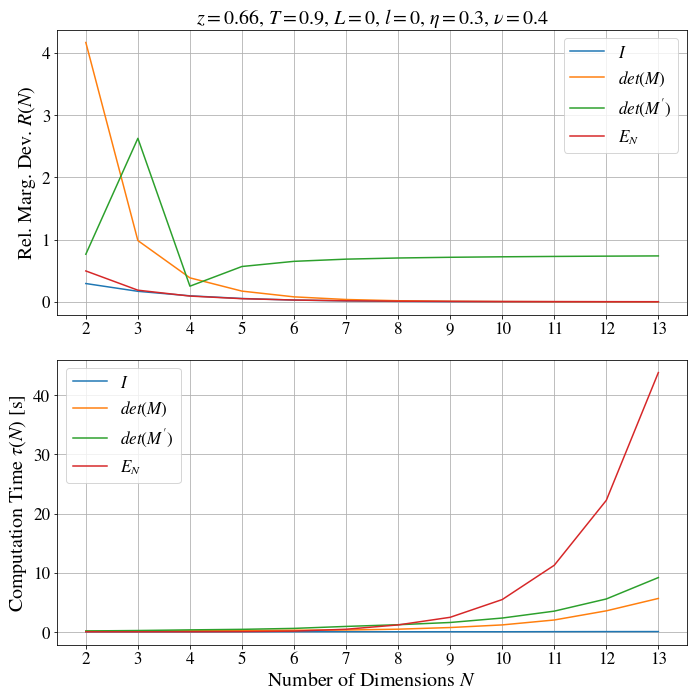

In [ ]:
#Convergence Test 1
Time=time.time()
plt.rcParams.update({'font.size': 17, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

z=0.66
Ls=0
Li=0
ls=0
li=0
T=0.9
y=[[],[],[],[]]
w=[[],[],[],[]]
lab=[]
Nmax=13
NN=np.arange(2,Nmax+1)

for N in NN:
    M=N+1
    A=State(z,T,M,Ls,Li,ls,li)
    B=State(z,T,N,Ls,Li,ls,li)

    tt=time.time()
    y[0].append(Rel(Agarwal(A,M), Agarwal(B,N)))
    w[0].append((time.time()-tt))
    lab.append("$I$")
    tt=time.time()
    y[1].append(Rel(DetMom3(z,T,M,Ls,Li,ls,li), DetMom3(z,T,N,Ls,Li,ls,li)))
    w[1].append((time.time()-tt))
    lab.append("$det(M)$")
    tt=time.time()
    y[2].append(Rel(DetMom(z,T,M,Ls,Li,ls,li,1,0), DetMom(z,T,N,Ls,Li,ls,li,1,0)))
    w[2].append((time.time()-tt))
    lab.append("$det(M')$")
    tt=time.time()
    y[3].append(Rel(LogNeg(A,M), LogNeg(B,N)))
    w[3].append((time.time()-tt))
    lab.append("$E_{N}$")

    print(N)

y=np.array(y)
w=np.array(w)

fig, ax=plt.subplots(2,1, figsize=(10,10))
#Conv
for i in range(len(y)):
    ax[0].plot(NN, y[i], label=lab[i])
#ax.plot(NN, y[i], label=lab[i])
ax[0].grid(True)
#ax[0].set_xlabel('Number of Dimensions $N$', fontsize=20) #
ax[0].set_ylabel(r"Rel. Marg. Dev. $R(N')$", fontsize=20) #
ax[0].set_xticks(NN)
ax[0].legend(loc=0)
ax[0].set_title("$z=$"+str(z)+", $T=$"+str(T)+", $L=$"+str(Ls)+", $l=$"+str(ls)+r", $\eta=$"+str(eta)+r", $\nu=$"+str(ny), fontsize=20) #Convergence:
#Time
for i in range(len(w)):
    ax[1].plot(NN, w[i], label=lab[i]) #Lab(i)
ax[1].grid(True)
ax[1].set_xlabel("Number of Dimensions $N'$", fontsize=20) #
ax[1].set_ylabel(r"Computation Time $\tau(N')$ [s]", fontsize=20) #
ax[1].set_xticks(NN)
ax[1].legend(loc=0)

fig.tight_layout()
fig.savefig("Conv1_z"+str(z)+"_T"+str(T)+"_Nmax"+str(Nmax)+"_L"+str(Ls)+"_l"+str(ls)+"_eta"+str(eta)+"_ny"+str(ny)+".pdf", bbox_inches='tight')

print("\nTime of Execution:",time.time()-Time,"seconds")

3
4
5
6
7
8
9
10
11
12
13

Time of Execution: 140.67281126976013 seconds


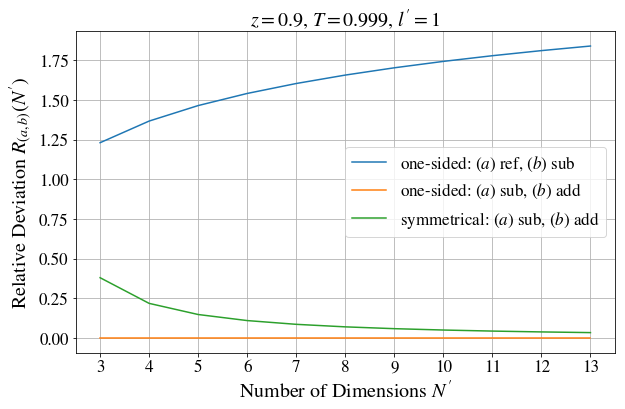

In [ ]:
#Convergence Test 2, LogNeg point in (m,n)
Time=time.time()
plt.rcParams.update({'font.size': 17, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

z=0.9
Ls=1
Li=1
ls=1
li=1
T=0.999
Nmax=13
NN=np.arange(3,Nmax+1)
y1=[]
y2=[]
y3=[]
ref=LNRef(z) #ref

for N in NN:
    A=State(z,T,N,0,0,ls,0) #sub
    B=State(z,T,N,Ls,0,0,0) #add
    AA=LogNeg(A,N)
    A2=State(z,T,N,0,0,ls,li) #sub2
    B2=State(z,T,N,Ls,Li,0,0) #add2
    AA2=LogNeg(A2,N)

    C=abs((AA-ref)/ref) #relative deviation: sub-ref
    D=abs((LogNeg(B,N)-AA)/AA) #relative deviation: of add-sub
    D2=abs((LogNeg(B2,N)-AA2)/AA2) #relative deviation: of add-sub

    y1.append(D)
    y2.append(C)
    y3.append(D2)
    print(N)

y1=np.array(y1)
y2=np.array(y2)
y3=np.array(y3)

fig=plt.figure(figsize=(9,6))
plt.plot(NN, y2, label="one-sided: $(a)$ ref, $(b)$ sub") #deviation
plt.plot(NN, y1, label="one-sided: $(a)$ sub, $(b)$ add") #add-sub
plt.plot(NN, y3, label="symmetrical: $(a)$ sub, $(b)$ add") #add-sub
plt.xticks(NN)
plt.xlabel("Number of Dimensions $N'$", fontsize=20)
plt.ylabel("Relative Deviation $R_{(a,b)}(N')$", fontsize=20)
plt.title("$z=$"+str(z)+", $T=$"+str(T)+", $l'=$"+str(ls), fontsize=20)
plt.legend(loc=0)
plt.grid(True)
plt.tight_layout()
plt.savefig("Conv2_z"+str(z)+"_T"+str(T)+"_Nmax"+str(Nmax)+"_L"+str(Ls)+"_l"+str(ls)+".pdf", bbox_inches='tight')

print("\nTime of Execution:",time.time()-Time,"seconds")

In [10]:
#Software Information
version_table()

Software,Version
QuTiP,4.3.1
Numpy,1.11.3
SciPy,1.1.0
matplotlib,2.2.3
Cython,0.28.5
Number of CPUs,2
BLAS Info,INTEL MKL
IPython,6.5.0
Python,"3.7.0 (default, Jun 28 2018, 08:04:48) [MSC v.1912 64 bit (AMD64)]"
OS,nt [win32]
